In [24]:
# Import libraries
import os
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray

In [25]:
# Data directory
data_dir = 'C:/Users/Holger/EGU_2021_lgeo_workshops/SC5.8/data'

In [26]:
# Import shapefile of the Baltics
shp_fp = os.path.join(data_dir, 'baltics_4326.shp')
baltics = gpd.read_file(shp_fp)
display(baltics.crs)
display(baltics.head())

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,CNTR_ID,CNTR_NAME,NAME_ENGL,ISO3_CODE,FID,geometry
0,LT,Lietuva,Lithuania,LTU,LT,"MULTIPOLYGON (((26.63037 55.68067, 26.63108 55..."
1,EE,Eesti,Estonia,EST,EE,"MULTIPOLYGON (((28.04191 59.47012, 28.04319 59..."
2,LV,Latvija,Latvia,LVA,LV,"MULTIPOLYGON (((27.35158 57.51824, 27.36511 57..."


<AxesSubplot:>

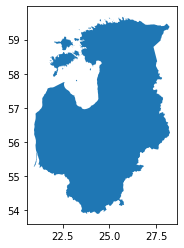

In [27]:
# Create clip polygon
clip_poly = baltics.dissolve()
clip_poly.plot()

In [28]:
# Open precipitation dataset and assign CRS
precip_fp = os.path.join(data_dir, 'rr_ens_mean_0.1deg_reg_v22.0e.nc')
with xr.open_dataset(precip_fp) as precip_ds:
    precip_ds.rio.write_crs('epsg:4326', inplace=True)
display(precip_ds.rio.crs)
display(precip_ds.attrs)
display(precip_ds.var)

CRS.from_epsg(4326)

{'E-OBS_version': '22.0e',
 'Conventions': 'CF-1.4',
 'References': 'http://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php',
 'history': 'Mon Nov 30 15:36:45 2020: ncks --no-abc -d time,0,25748 /data2/Else/EOBSv22.0e/Grid_0.1deg/rr//rr_ensmean_master_rectime.nc /data2/Else/EOBSv22.0e/Grid_0.1deg/rr//rr_ens_mean_0.1deg_reg_v22.0e.nc\nMon Nov 30 15:34:40 2020: ncks --no-abc --mk_rec_dmn time /data2/Else/EOBSv22.0e/Grid_0.1deg/rr//rr_ensmean_master.nc /data2/Else/EOBSv22.0e/Grid_0.1deg/rr//rr_ensmean_master_rectime.nc',
 'NCO': 'netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)',
 'grid_mapping': 'spatial_ref'}

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:      (latitude: 465, longitude: 705, time: 25749)
Coordinates:
  * longitude    (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude     (latitude) float64 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * time         (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-06-30
    spatial_ref  int32 0
Data variables:
    rr           (time, latitude, longitude) float32 ...
Attributes:
    E-OBS_version:  22.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Mon Nov 30 15:36:45 2020: ncks --no-abc -d time,0,25748 /...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....
    grid_mapping:   spatial_ref>

In [8]:
# Time series end date
display(str(precip_ds['time'].max().values))

'2020-06-30T00:00:00.000000000'

'2020-06-30T00:00:00.000000000'

In [29]:
# Create lists for first ad last dates of months in the time frame
timeframe_start = '2001-01-01'
timeframe_end = '2020-06-30'
first_days = pd.date_range(timeframe_start, timeframe_end, freq='1M') - pd.offsets.MonthBegin(1)
last_days = pd.date_range(timeframe_start, timeframe_end, freq='1M') + pd.offsets.MonthEnd(0)
display(first_days[:12])
display(last_days[:-1])

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01'],
              dtype='datetime64[ns]', freq=None)

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31'],
              dtype='datetime64[ns]', length=233, freq=None)

In [37]:
# Create a new dataset with monthly precipitation sum values as variables
dataset = xr.Dataset()
for first, last in zip(first_days, last_days):
    first = first.strftime('%Y-%m-%d')
    last = last.strftime('%Y-%m-%d')
    date_strings = first.split('-')
    year_month = '-'.join([date_strings[0], date_strings[1]])
    ds_slice = precip_ds.sel(time=slice(first, last))
    ds_slice_clip = ds_slice.rio.clip(clip_poly.geometry, clip_poly.crs)
    ds_slice_clip = ds_slice_clip.sum('time')
    dataset[year_month] = ds_slice_clip.to_array()
display(dataset.var)

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, variable: 1)
Coordinates:
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
    spatial_ref  int32 0
  * variable     (variable) <U2 'rr'
Data variables: (12/234)
    2001-01      (variable, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    2001-02      (variable, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    2001-03      (variable, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    2001-04      (variable, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    2001-05      (variable, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    2001-06      (variable, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
    ...           ...
    2020-01      (variable, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
   

In [38]:
# Write precipitation data into NetCDF
dataset.to_netcdf(os.path.join(data_dir, 'precip_balt.nc'))

In [39]:
# Repeat procedure with monthly mean temperature data
temp_fp = os.path.join(data_dir, 'tg_ens_mean_0.1deg_reg_v22.0e.nc')
with xr.open_dataset(temp_fp) as temp_ds:
    temp_ds.rio.write_crs('epsg:4326', inplace=True)
display(temp_ds.rio.crs)
display(temp_ds.attrs)
display(temp_ds.var)
dataset = xr.Dataset()
for first, last in zip(first_days, last_days):
    first = first.strftime('%Y-%m-%d')
    last = last.strftime('%Y-%m-%d')
    date_strings = first.split('-')
    year_month = '-'.join([date_strings[0], date_strings[1]])
    ds_slice = temp_ds.sel(time=slice(first, last))
    ds_slice_clip = ds_slice.rio.clip(clip_poly.geometry, clip_poly.crs)
    ds_slice_clip = ds_slice_clip.mean('time')
    dataset[year_month] = ds_slice_clip.to_array()
display(dataset.var)

CRS.from_epsg(4326)

{'E-OBS_version': '22.0e',
 'Conventions': 'CF-1.4',
 'References': 'http://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php',
 'history': 'Mon Nov 30 14:47:39 2020: ncks --no-abc -d time,0,25748 /data2/Else/EOBSv22.0e/Grid_0.1deg/tg//tg_ensmean_master_rectime.nc /data2/Else/EOBSv22.0e/Grid_0.1deg/tg//tg_ens_mean_0.1deg_reg_v22.0e.nc\nMon Nov 30 14:43:19 2020: ncks --no-abc --mk_rec_dmn time /data2/Else/EOBSv22.0e/Grid_0.1deg/tg//tg_ensmean_master.nc /data2/Else/EOBSv22.0e/Grid_0.1deg/tg//tg_ensmean_master_rectime.nc',
 'NCO': 'netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)',
 'grid_mapping': 'spatial_ref'}

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:      (latitude: 465, longitude: 705, time: 25749)
Coordinates:
  * longitude    (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude     (latitude) float64 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * time         (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-06-30
    spatial_ref  int32 0
Data variables:
    tg           (time, latitude, longitude) float32 ...
Attributes:
    E-OBS_version:  22.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Mon Nov 30 14:47:39 2020: ncks --no-abc -d time,0,25748 /...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....
    grid_mapping:   spatial_ref>

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, variable: 1)
Coordinates:
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
    spatial_ref  int32 0
  * variable     (variable) <U2 'tg'
Data variables: (12/234)
    2001-01      (variable, latitude, longitude) float32 nan nan nan ... nan nan
    2001-02      (variable, latitude, longitude) float32 nan nan nan ... nan nan
    2001-03      (variable, latitude, longitude) float32 nan nan nan ... nan nan
    2001-04      (variable, latitude, longitude) float32 nan nan nan ... nan nan
    2001-05      (variable, latitude, longitude) float32 nan nan nan ... nan nan
    2001-06      (variable, latitude, longitude) float32 nan nan nan ... nan nan
    ...           ...
    2020-01      (variable, latitude, longitude) float32 nan nan nan ... nan nan
   

In [40]:
# Write temperature data into NetCDF
dataset.to_netcdf(os.path.join(data_dir, 'temp_balt.nc'))